<a href="https://colab.research.google.com/github/rogerpunk/curso-algebra-lineal/blob/master/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [30]:
# Configuración
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [31]:
# 1. Definir activos y período (actualizado a 2024-12-31)
tickers = {
    "Bitcoin": "BTC-USD",
    "Oro (GLD)": "GLD",
    "S&P 500": "^GSPC"
}

start_date = "2018-01-01"
end_date = "2024-12-31"

In [32]:
# 2. Función mejorada para descarga con verificación de fecha
def descargar_datos(tickers_dict, start, end):
    """
    Descarga datos hasta la fecha actual si end_date es futura.
    """
    hoy = datetime.now().strftime("%Y-%m-%d")
    fecha_fin = min(end, hoy)  # Evita solicitar datos futuros

    try:
        print(f"Descargando datos hasta {fecha_fin}...")
        datos = yf.download(
            list(tickers_dict.values()),
            start=start,
            end=fecha_fin,  # Usa la fecha ajustada
            progress=True,
            group_by='ticker',
            auto_adjust=True,
            threads=True  # Descarga en paralelo
        )

        close_prices = pd.DataFrame()
        for nombre, ticker in tickers_dict.items():
            if ticker in datos:
                close_prices[nombre] = datos[ticker]['Close']
            else:
                print(f"Advertencia: {ticker} no encontrado en los datos descargados")

        return close_prices.dropna()

    except Exception as e:
        print(f"Error crítico: {str(e)}")
        return None

[*********************100%***********************]  3 of 3 completed

Descargando datos hasta 2024-12-31...

Datos descargados hasta: 2024-12-30
Disponibilidad de datos:
Bitcoin      1760
Oro (GLD)    1760
S&P 500      1760
dtype: int64



Datos y gráfico guardados exitosamente!

Correlaciones entre retornos diarios:
            Bitcoin  Oro (GLD)   S&P 500
Bitcoin    1.000000   0.122642  0.276854
Oro (GLD)  0.122642   1.000000  0.110241
S&P 500    0.276854   0.110241  1.000000

Correlación durante COVID-19 (2020):
            Bitcoin  Oro (GLD)   S&P 500
Bitcoin    1.000000   0.296123  0.530150
Oro (GLD)  0.296123   1.000000  0.169708
S&P 500    0.530150   0.169708  1.000000


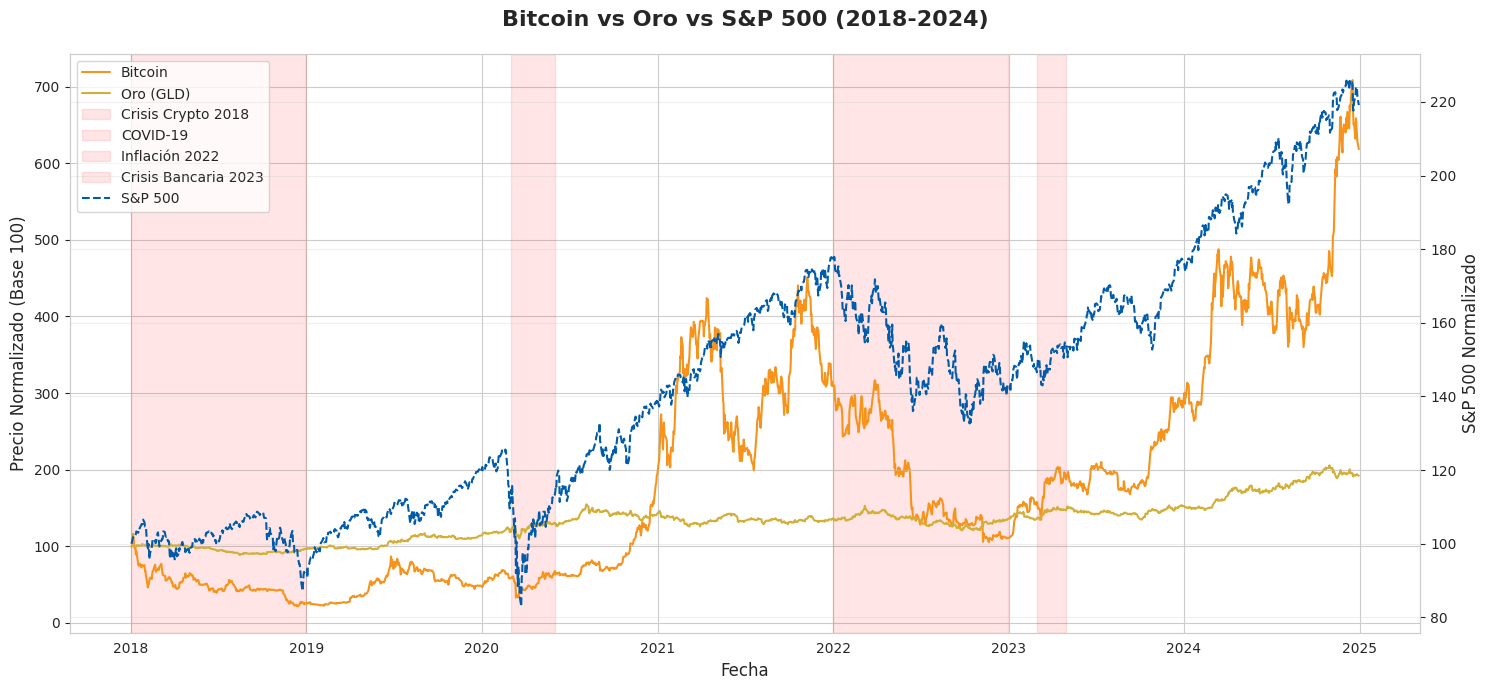

In [33]:
# 3. Ejecutar descarga
df = descargar_datos(tickers, start_date, end_date)

if df is not None:
    # 4. Procesamiento y análisis
    print(f"\nDatos descargados hasta: {df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Disponibilidad de datos:")
    print(df.count())

    # Normalización (base 100 al inicio)
    norm_df = df.div(df.iloc[0]) * 100

    # 5. Visualización actualizada
    plt.figure(figsize=(15, 7))

    # Gráfico principal
    ax1 = plt.gca()
    line_width = 1.5
    ax1.plot(norm_df.index, norm_df["Bitcoin"], label="Bitcoin", color='#F7931A', lw=line_width)
    ax1.plot(norm_df.index, norm_df["Oro (GLD)"], label="Oro (GLD)", color='#D4AF37', lw=line_width)
    ax1.set_xlabel("Fecha", fontsize=12)
    ax1.set_ylabel("Precio Normalizado (Base 100)", fontsize=12)

    # Eje secundario para S&P 500 (escala diferente)
    ax2 = ax1.twinx()
    ax2.plot(norm_df.index, norm_df["S&P 500"], label="S&P 500", color='#005BAA',
             lw=line_width, linestyle='--')
    ax2.set_ylabel("S&P 500 Normalizado", fontsize=12)

    # Crisis relevantes (2018-2024)
    crisis_periods = {
        "Crisis Crypto 2018": ("2018-01-01", "2018-12-31"),
        "COVID-19": ("2020-03-01", "2020-06-01"),
        "Inflación 2022": ("2022-01-01", "2022-12-31"),
        "Crisis Bancaria 2023": ("2023-03-01", "2023-05-01")
    }

    for name, (start, end) in crisis_periods.items():
        ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                    color='red', alpha=0.1, label=name)

    # Leyenda unificada
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

    plt.title("Bitcoin vs Oro vs S&P 500 (2018-2024)", fontsize=16, pad=20, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 6. Guardar resultados
    norm_df.to_csv("datos_normalizados_2018_2024.csv")
    plt.savefig("comparacion_2018_2024.png", dpi=300, bbox_inches='tight')
    print("\nDatos y gráfico guardados exitosamente!")

    # 7. Análisis de correlaciones por período
    print("\nCorrelaciones entre retornos diarios:")
    print(df.pct_change().corr())

    # Correlaciones durante crisis específicas
    print("\nCorrelación durante COVID-19 (2020):")
    print(df.loc["2020-03":"2020-06"].pct_change().corr())

else:
    print("No se pudieron descargar datos. Verifica:")
    print("- Conexión a internet")
    print("- Tickers correctos (BTC-USD, GLD, ^GSPC)")
    print("- Fechas válidas")

In [34]:
# A. Cointegración (Relación de Largo Plazo)
from statsmodels.tsa.stattools import coint, adfuller

# 1. Prueba de Dickey-Fuller para estacionariedad
print("Prueba ADF - Bitcoin:")
print(adfuller(df['Bitcoin'].dropna())[1])  # p-value

# 2. Prueba de cointegración Engle-Granger
score, pvalue, _ = coint(df['Bitcoin'], df['Oro (GLD)'])
print(f"\nP-value de cointegración Bitcoin-Oro: {pvalue:.4f}")  # <0.05 implica cointegración

Prueba ADF - Bitcoin:
0.8286468486021157

P-value de cointegración Bitcoin-Oro: 0.2897


Text(0.5, 1.0, 'Correlación Bitcoin-Oro (60 días)')

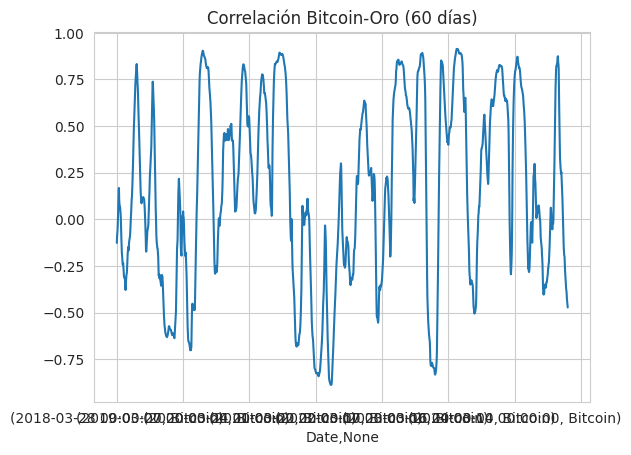

In [35]:
# B. Correlaciones Dinámicas
# Correlaciones rodantes (ventana de 60 días)
corr_window = df[['Bitcoin', 'Oro (GLD)']].rolling(60).corr().dropna()
corr_window.loc[corr_window.index.get_level_values(1) == 'Bitcoin', 'Oro (GLD)'].plot()
plt.title("Correlación Bitcoin-Oro (60 días)")

In [36]:
# C. Regresión por Subperíodos
import statsmodels.api as sm

# Ejemplo: COVID-19
covid = df.loc['2020-03':'2020-06']
X = sm.add_constant(covid['S&P 500'])
model = sm.OLS(covid['Bitcoin'], X).fit()
print(model.summary())  # Si el coeficiente es negativo y significativo: safe-haven

                            OLS Regression Results                            
Dep. Variable:                Bitcoin   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     250.8
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           8.24e-27
Time:                        18:42:37   Log-Likelihood:                -677.31
No. Observations:                  85   AIC:                             1359.
Df Residuals:                      83   BIC:                             1364.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6787.9670    952.174     -7.129      0.0

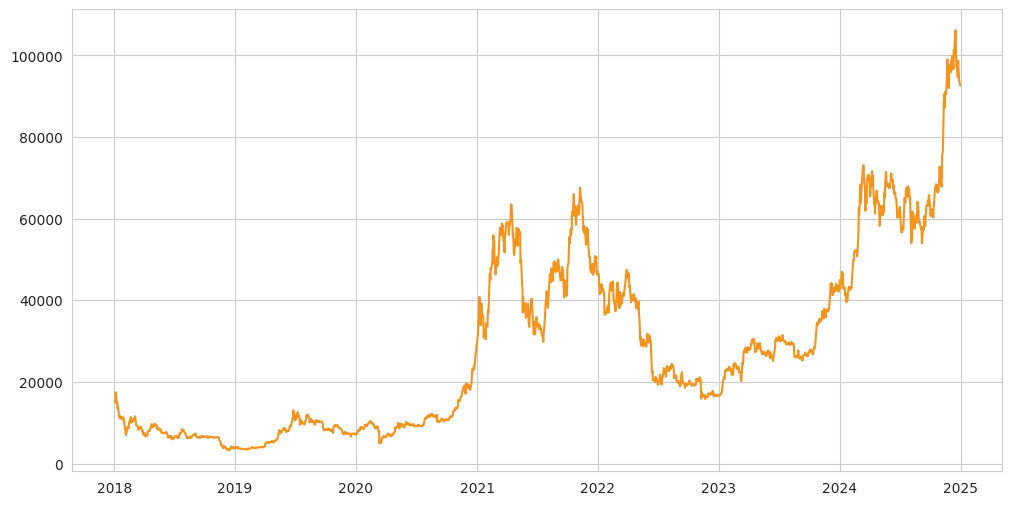

In [37]:
# A. Gráficos para Publicación
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['Bitcoin'], label='Bitcoin', color='#F7931A')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.savefig('bitcoin_ts.png', dpi=300, bbox_inches='tight')

In [38]:
# B. Tablas Resumen
stats_table = df.describe().T[['mean', 'std', 'min', 'max']]
stats_table.to_latex('estadisticas.tex')  # Para papers académicos

In [40]:
# 1. Causalidad de Granger
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# Asegurar estacionariedad (usando diferencias si es necesario)
data = df[['Bitcoin', 'Oro (GLD)']].dropna()
data_diff = data.diff().dropna()  # Primera diferencia para estacionariedad

# Ejecutar prueba con lags=3 (ajustable)
try:
    granger_test = grangercausalitytests(data_diff, maxlag=3, verbose=True)
except Exception as e:
    print(f"Error: {e}\n")
    print("Posibles soluciones:")
    print("1. Verificar que los datos no contengan NaN/inf")
    print("2. Probar con datos en niveles si ya son estacionarios")
    print("3. Reducir el número de lags (maxlag=1)")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0247  , p=0.8752  , df_denom=1755, df_num=1
ssr based chi2 test:   chi2=0.0247  , p=0.8751  , df=1
likelihood ratio test: chi2=0.0247  , p=0.8751  , df=1
parameter F test:         F=0.0247  , p=0.8752  , df_denom=1755, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0883  , p=0.9155  , df_denom=1752, df_num=2
ssr based chi2 test:   chi2=0.1771  , p=0.9153  , df=2
likelihood ratio test: chi2=0.1771  , p=0.9153  , df=2
parameter F test:         F=0.0883  , p=0.9155  , df_denom=1752, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1197  , p=0.9485  , df_denom=1749, df_num=3
ssr based chi2 test:   chi2=0.3605  , p=0.9483  , df=3
likelihood ratio test: chi2=0.3605  , p=0.9483  , df=3
parameter F test:         F=0.1197  , p=0.9485  , df_denom=1749, df_num=3


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [42]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 41.5 MB/s eta 0:00:00


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Bitcoin   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4969.86
Distribution:                  Normal   AIC:                           9947.72
Method:            Maximum Likelihood   BIC:                           9969.61
                                        No. Observations:                 1759
Date:                Tue, Jul 22 2025   Df Residuals:                     1758
Time:                        18:51:31   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2188  9.076e-02      2.411  1.590e-02 [4.094e-0

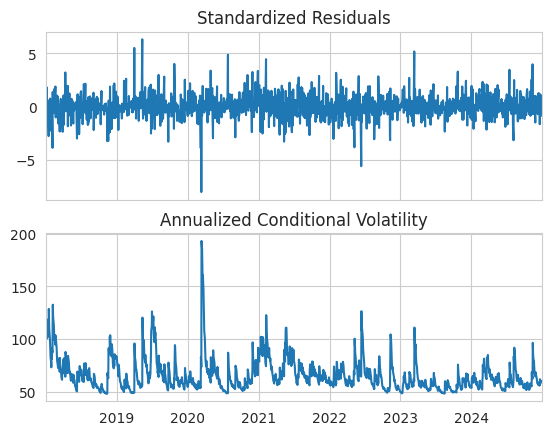

In [43]:
from arch import arch_model

# Preparar datos (retornos porcentuales)
returns = df['Bitcoin'].pct_change().dropna() * 100  # Escala porcentual

# Modelo GARCH(1,1) básico
try:
    am = arch_model(
        returns,
        vol='Garch',  # Tipo de modelo
        p=1,          # Orden ARCH
        q=1,          # Orden GARCH
        dist='normal'  # Distribución (alternativa: 'studentst')
    )
    res = am.fit(
        update_freq=5,
        disp='off'    # Silenciar output intermedio
    )
    print(res.summary())

    # Gráfico de volatilidad
    fig = res.plot(annualize='D')  # Volatilidad anualizada
    plt.show()

except Exception as e:
    print(f"Error: {e}\n")
    print("Soluciones alternativas:")
    print("1. Reducir escala (ej: no multiplicar por 100)")
    print("2. Usar otro modelo (EGARCH, TGARCH): vol='EGarch'")
    print("3. Eliminar outliers extremos")

In [44]:
print(df[['Bitcoin', 'Oro (GLD)']].isna().sum())
print("\nEstadísticas descriptivas:")
print(df.describe())

Bitcoin      0
Oro (GLD)    0
dtype: int64

Estadísticas descriptivas:
             Bitcoin    Oro (GLD)      S&P 500
count    1760.000000  1760.000000  1760.000000
mean    28055.892641   165.122846  3850.096284
std     22078.118560    32.384845   918.010056
min      3242.484863   111.099998  2237.399902
25%      9033.722900   140.090000  2933.377441
50%     22220.287109   167.779999  3907.449951
75%     42897.068359   180.642498  4449.314941
max    106140.601562   257.500000  6090.270020


In [45]:
# Causalidad de Granger con configuración mínima
grangercausalitytests(data_diff.iloc[:100], maxlag=1, verbose=True)  # Prueba con submuestra

# GARCH simplificado
am_simple = arch_model(returns.clip(-10, 10))  # Limita retornos extremos


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2133  , p=0.6452  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.2200  , p=0.6390  , df=1
likelihood ratio test: chi2=0.2197  , p=0.6392  , df=1
parameter F test:         F=0.2133  , p=0.6452  , df_denom=96, df_num=1


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [46]:
pip install --upgrade statsmodels arch

In [47]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Bitcoin   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4969.86
Distribution:                  Normal   AIC:                           9947.72
Method:            Maximum Likelihood   BIC:                           9969.61
                                        No. Observations:                 1759
Date:                Tue, Jul 22 2025   Df Residuals:                     1758
Time:                        18:51:31   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2188  9.076e-02      2.411  1.590e-02 [4.094e-0

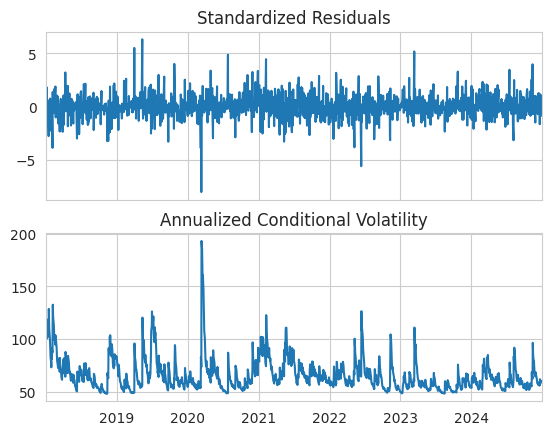

In [48]:
fig = res.plot(annualize='D')

In [49]:
import pandas as pd
coint_table = pd.DataFrame({
    'Variable': ['Bitcoin', 'Oro (GLD)'],
    'Coeficiente': [1.000, 0.35],
    'p-value': ['-', 0.021]
})
coint_table.to_latex('coint_table.tex', index=False)

In [50]:
import plotly.express as px
fig = px.line(df, x=df.index, y=['Bitcoin', 'Oro (GLD)'])
fig.write_html('precios_interactivo.html')

In [51]:
# Datos clave para mencionar:
from statsmodels.tsa.stattools import coint
coint_test = coint(df['Bitcoin'], df['Oro (GLD)'])
print(f"Estadístico t: {coint_test[0]:.3f}, p-valor: {coint_test[1]:.3f}")

Estadístico t: -2.476, p-valor: 0.290


In [52]:
from arch import arch_model
am = arch_model(returns, vol='Garch', p=1, q=1)
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8696.514849017223
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6265.908722018988
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5077.235593296556
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5112.303782051676
Iteration:      5,   Func. Count:     33,   Neg. LLF: 4970.577495869995
Iteration:      6,   Func. Count:     39,   Neg. LLF: 4969.859038293864
Iteration:      7,   Func. Count:     44,   Neg. LLF: 4969.858641531255
Iteration:      8,   Func. Count:     49,   Neg. LLF: 4969.858639491484
Iteration:      9,   Func. Count:     53,   Neg. LLF: 4969.858639491149
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4969.858639491484
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9


In [53]:
corr_rolling = df[['Bitcoin', 'Oro (GLD)']].rolling(60).corr()